# Global

In [7]:
# METTI COMMENTI STILE PEP8 PER OGNI FUNZIONE
# METTI TQDM IN EDA
global_var = {
    # Data
    'data_path': "/content/vessel_data",
    'prefix': "https://drive.google.com/uc?export=",
    'bifurcating_data_id': "download&id=1bzXusjOMgh-5hnw6RDNc03UUktQixtL4",
    'single_data_id': "download&id=19AHhDU1UWBzpG33wlB1r7b6sH3lMVly5",
    'current_name': "bifurcating",

    # Datasets
    'single_path': "./single/single.hdf5",
    'bifurcating_path': "./bifurcating/bifurcating.hdf5",
    'dataset_path': "./dataset.hdf5",
    'train_path': "./train.hdf5",
    'test_path': "./test.hdf5",

    # Datasets quality check
    'data_length': 2000,
    'data_keys': ['face', 'inlet_idcs', 'pos', 'pressure', 'wss'],

    # Geometric algebra
    'ga_dimension': 16,

    # Train
    'train_test_split': 0.8,
    'validation_split': 0.1,
    'batch_size': 32,
    'num_workers': 2,
}

# Imports

In [8]:
!pip install wget pytorch_lightning torchvision --quiet

In [9]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import pytorch_lightning as pl
import pandas as pd
import re
import sys
import torch
import torch.nn as nn
import wget
import zipfile

from pytorch_lightning import LightningModule
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

# Dataset

## Download datasets

In [4]:
def bar_progress(current,total,width = 80):
    """
        Simple bar to track the download list of links
        associated with patches in the dataset

        Args:
            current: current byte number
            total: total byte number
            width: visual length of the bar
    """
    progress = current / total * 100
    progress_string = f"{progress} % [{current} / {total}] bytes"
    name = global_var['current_name']
    description = f"[{name}] Recovering links: " + progress_string
    sys.stdout.write("\r" + description)
    sys.stdout.flush()

In [5]:
def get_links_list(list_link,dataset_name):
    """
        Download the file with the links referred to
        the dataset patches

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log

        Returns:
            links: list of the zipped dataset patches
    """
    global_var['current_name'] = dataset_name
    list_name = wget.download(list_link,bar = bar_progress)
    links = pkl.load(open(list_name, 'rb'))
    os.remove(list_name)
    os.makedirs(dataset_name, exist_ok = True)

    return links

In [6]:
def unzip_data_patches(links,dataset_name,debug):
    """
        Unzip the downloaded file patches to obtain the respective HDF5
        file within them, cleaning up excess files when finished

        Args:
            links: list with the links referred to file to download
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function

        Returns:
            hdf5_patches: list of HDF5 files
    """
    cnt = 0 if debug else None
    hdf5_patches = []

    tqdm_desc = f"[{dataset_name}] Downloading and unzipping data patches"
    for link in tqdm(links,desc = tqdm_desc):
        name = wget.download(link)
        with zipfile.ZipFile(name, 'r') as zip_ref:
            zip_ref.extractall("/content/")
            hdf5_patches.append(name.replace(".zip",".hdf5"))
            os.remove(name)
            if debug:
                cnt +=1
            if debug and cnt > 3:
                break
    return hdf5_patches

In [7]:
def compose_dataset(dataset_file,dataset_name,hdf5_patches):
    """
        Merge several HDF5 files into one,

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name
            hdf5_patches: list of file to merge
    """
    with h5py.File(dataset_file, 'w') as file_dest:
        tqdm_desc = f"[{dataset_name}] Composing HDF5 full dataset"
        for file_origine in tqdm(hdf5_patches,desc = tqdm_desc):
            percorso_file_origine = os.path.join("/content/", file_origine)

            with h5py.File(percorso_file_origine, 'r') as file_orig:
                for gruppo_nome, gruppo in file_orig.items():
                    gruppo_dest = file_dest.create_group(gruppo_nome)

                    for data_name, dataset in gruppo.items():
                        gruppo_dest.create_dataset(data_name, data=dataset[()])

    for file in hdf5_patches:
        percorso_file = os.path.join("/content/", file)
        os.remove(percorso_file)

In [8]:
def quality_check(dataset_file,dataset_name):
    """
        Check that the final dataset meets the standards

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name used for log

        Returns:
            (Boolean): logical result of the check
    """
    print(f"[{dataset_name}]\033[1m Dataset quality check \033[0m")

    with h5py.File(dataset_file, 'r') as dataset:
        # Check correct length
        len_condition = (len(dataset) == global_var['data_length'])
        if len_condition:
            error_str = "All samples present in the dataset \u2714"
            print(f"[{dataset_name}] " + error_str)
        else:
            missing_samples = global_var['data_length'] - len(dataset)
            error_str = "Not all samples are in the dataset \u2718"
            print(f"[{dataset_name}] " + error_str)
            if missing_samples > 1:
                print(f"[{dataset_name}] \t -> {missing_samples} is missing")
            else:
                print(f"[{dataset_name}] \t -> {missing_samples} are missing")
            return False

        # Check correct keys
        keys_condition = True
        for sample in list(dataset.keys()):
            correct_keys = list(dataset[sample].keys())
            current_keys = global_var['data_keys']
            keys_condition = keys_condition and (correct_keys == current_keys)
            if not keys_condition:
                problematic_sample = sample
                break
        if keys_condition:
            print(f"[{dataset_name}] All samples keys are correct \u2714")
        else:
            print(f"[{dataset_name}] Error in samples keys \u2718")
            print(f"[{dataset_name}] \t -> Check {problematic_sample}")
            return False

        # Check correct ordering
        ordering_condition = True
        numbers = [re.search(r'_\d+', s).group()[1:] for s in dataset.keys()]
        for n in range(len(numbers)):
            counter = f'{n:04d}'
            ordering_condition = ordering_condition and (numbers[n] == counter)
            if numbers[n] != counter:
                problematic_sample = counter
            break

        if ordering_condition:
            print(f"[{dataset_name}] Samples are ordered \u2714")
        else:
            print(f"[{dataset_name}] Samples are NOT ordered \u2718")
            print(f"[{dataset_name}] \t -> Check {counter}")
            return False

    return True

In [9]:
def download_dataset(list_link, dataset_name, debug):
    """
        Download the dataset divided into several patches,
        assemble it and check that the operation is successful

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function
    """
    dataset_file = dataset_name + "/" + dataset_name + ".hdf5"
    if not os.path.exists(dataset_name):
        links = get_links_list(list_link,dataset_name)
        hdf5_patches = unzip_data_patches(links,dataset_name,debug)
        compose_dataset(dataset_file,dataset_name,hdf5_patches)
        check = quality_check(dataset_file,dataset_name)

        if check:
            success_string = "Dataset correctly downloaded \033[0m\u2714"
            print(f"[{dataset_name}] \u2714\033[1m " + success_string)
        else:
            error_string = "Dataset download failed \033[0m\u2718"
            print(f"[{dataset_name}] \u2718\033[1m " + error_string)
    else:
        done_string = f"Dataset is already available in {dataset_file}"
        print(f"[{dataset_name}] " + done_string)

In [10]:
bifurcating_link = global_var['prefix'] + global_var["bifurcating_data_id"]
download_dataset(
    list_link = bifurcating_link,
    dataset_name = "bifurcating",
    debug = False
)

[bifurcating] Recovering links: 100.0 % [8708 / 8708] bytes

[bifurcating] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Dataset quality check 
[bifurcating] All samples present in the dataset ✔
[bifurcating] All samples keys are correct ✔
[bifurcating] Samples are ordered ✔
[bifurcating] ✔ Dataset correctly downloaded ✔


In [11]:
single_link = global_var['prefix'] + global_var["single_data_id"]
download_dataset(
    list_link = single_link,
    dataset_name = "single",
    debug = False
)

[single] Recovering links: 100.0 % [8708 / 8708] bytes

[single] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Dataset quality check 
[single] All samples present in the dataset ✔
[single] All samples keys are correct ✔
[single] Samples are ordered ✔
[single] ✔ Dataset correctly downloaded ✔


## Train and test data

In [12]:
def copy_data(source, destination, new_sample, old_sample, label):
    destination.create_group(new_sample)
    for field in list(source[old_sample].keys()):
        new_field_data = source[old_sample][field][()]
        destination[new_sample].create_dataset(field, data = new_field_data)

    destination[new_sample].create_dataset('label', data = np.array([label]))

In [13]:
def shuffle_dataset(temp_dataset,dataset):
    with h5py.File(temp_dataset, 'r') as file:
        # Extract group names (assuming they are 'sample_0000', etc.)
        sample_names = list(file.keys())

        # Shuffle indices
        shuffled_indices = np.random.permutation(len(sample_names))

        # Create a new shuffled HDF5 file
        with h5py.File(dataset, 'w') as shuffled_file:
            values = enumerate(shuffled_indices)
            iters = len(shuffled_indices)
            shuffle_desc = '[LOG] Shuffling dataset'

            for new_index, old_index in tqdm(
                values,
                total = iters,
                desc = shuffle_desc
            ):
                sample = f'sample_{new_index:04d}'
                old_name = f'sample_{old_index:04d}'
                shuffled_file.create_group(sample)
                for field in file[old_name]:
                    shuffled_file[sample][field] = file[old_name][field][()]

    os.remove(temp_dataset)

In [14]:
def train_test_split(dataset):
    with h5py.File(dataset, 'r') as file:
        total_rows = len(file)

        # Calculates the number of rows for each set
        train_rows = int(global_var['train_test_split'] * total_rows)
        test_rows = total_rows - train_rows

        if not os.path.exists(global_var['train_path']):
            # Create a new HDF5 file for the training set
            with h5py.File(global_var['train_path'], 'w') as train_file:
                iters = range(train_rows)
                train_desc = "[LOG] Composing train set"

                for i in tqdm(iters,desc = train_desc):
                    sample = f'sample_{i:04d}'
                    train_file.create_group(sample)

                    for field in file['sample_0000']:
                        train_file[sample][field] = file[sample][field][()]

        if not os.path.exists(global_var['test_path']):
            # Create a new HDF5 file for the test set
            with h5py.File(global_var['test_path'], 'w') as test_file:
                iters = range(train_rows, total_rows)
                test_desc = "[LOG] Composing test set"

                for i in tqdm(iters,desc = test_desc):
                    sample = f'sample_{i:04d}'
                    test_file.create_group(f'sample_{i:04d}')

                    for field in file['sample_0000']:
                        sample = f'sample_{i:04d}'
                        test_file[sample][field] = file[sample][field][()]

    os.remove(dataset)

In [15]:
def merge_datasets(single_path,bifurcating_path,debug = False):
    train_condition = os.path.exists(global_var['train_path'])
    test_condition = os.path.exists(global_var['test_path'])
    start_condition =  train_condition and test_condition

    if debug or not start_condition:
        with h5py.File(single_path, 'r') as single, \
            h5py.File(bifurcating_path, 'r') as bifurcating:
            signle_len = range(len(single))
            bifurcating_len = range(len(bifurcating))

            dataset_path = global_var['dataset_path']
            temp_dataset = dataset_path.replace(".hdf5", "_temp.hdf5")
            with h5py.File(temp_dataset, 'w') as dataset:
                single_desc = "[single] Copying data"
                for single_idx in tqdm(signle_len, desc = single_desc):
                    sample_name = f'sample_{single_idx:04d}'
                    label = 0
                    copy_data(
                        source = single,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = sample_name,
                        label = label
                     )

                bifurcating_desc = "[bifurcating] Copying data"
                for bif_idx in tqdm(bifurcating_len, desc = bifurcating_desc):
                    sample_name = f'sample_{bif_idx + 2000:04d}'
                    old_sample_name = f'sample_{bif_idx:04d}'
                    label = 1
                    copy_data(
                        source = bifurcating,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = old_sample_name,
                        label = label
                     )

        shuffle_dataset(temp_dataset,global_var['dataset_path'])
        train_test_split(global_var['dataset_path'])
    else:
        print("[LOG] Train and test sets already available")

In [16]:
merge_datasets(
    single_path = global_var['single_path'],
    bifurcating_path = global_var['bifurcating_path'],
    debug = True
)

[single] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[bifurcating] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[LOG] Shuffling dataset:   0%|          | 0/4000 [00:00<?, ?it/s]

[LOG] Composing train set:   0%|          | 0/3200 [00:00<?, ?it/s]

[LOG] Composing test set:   0%|          | 0/800 [00:00<?, ?it/s]

## Embedding in geometric algebra

In [17]:
def get_pos_mv(pos):
    mv = torch.zeros(pos.shape[0], global_var['ga_dimension'])

    mv[..., 14] = 1 # homogeneous coordinates
    mv[..., 11] = pos[..., 0] # x-coordinate of pos
    mv[..., 12] = pos[..., 1] # y-coordinate of pos
    mv[..., 13] = pos[..., 2] # z-coordinate of pos

    return mv

In [18]:
def get_face_mv(face):
    mv = torch.zeros(face.shape[0], global_var['ga_dimension'])

    mv[..., 2] = face[..., 0]
    mv[..., 3] = face[..., 1]
    mv[..., 4] = face[..., 2]

    return mv

In [19]:
def get_wss_mv(wss):
    mv = torch.zeros(wss.shape[0], global_var['ga_dimension'])

    mv[..., 0] = 1 # homogeneous coordinates

    mv[..., 5] = 0.5 * wss[..., 0]
    mv[..., 6] = 0.5 * wss[..., 1]
    mv[..., 7] = 0.5 * wss[..., 2]

    return mv

In [20]:
def get_inlet_mv(inlet):
    mv = torch.zeros(inlet.shape[0], global_var['ga_dimension'])

    mv[..., 0] = inlet

    return mv

In [21]:
def get_pressure_mv(pressure):
    mv = torch.zeros(pressure.shape[0], global_var['ga_dimension'])

    mv[..., 0] = pressure

    return mv

In [22]:
def embed_data(sample):
    # 'pos' property modeled as a point
    input_pos = torch.tensor(np.array(sample['pos']))
    pos_mv = get_pos_mv(input_pos)

    # 'face' property modeled as a plane
    input_face = torch.tensor(np.array(sample['face']))
    face_mv = get_face_mv(input_face)

    # 'wss' property modeled as a translation
    input_wss = torch.tensor(np.array(sample['wss']))
    wss_mv = get_wss_mv(input_wss)

    # 'inlet' modeled as a scalar
    input_inlet = torch.tensor(np.array(sample['inlet_idcs']))
    inlet_mv = get_inlet_mv(input_inlet)

    # 'pressure' modeled as a scalar
    input_pressure = torch.tensor(np.array(sample['pressure']))
    pressure_mv = get_pressure_mv(input_pressure)

    total_mvs = torch.cat([pos_mv, face_mv, wss_mv,inlet_mv, pressure_mv],dim=0)

    return total_mvs

## Pytorch dataset

In [23]:
class VesselDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.transform = transforms.Compose([embed_data])
        with h5py.File(file_path, 'r') as file:
            self.sample_names = list(file.keys())

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, index):
        sample_name = self.sample_names[index]

        with h5py.File(self.file_path, 'r') as file:
            multivector = self.transform(file[sample_name])
            # multivector = file[sample_name]
            label = torch.tensor(file[sample_name]['label'][()])

        return multivector,label
        # return label

## Lightning DataModule

In [24]:
def default_collate(batch):
    """
    Override `default_collate` https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader

    Reference:
    def default_collate(batch) at https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader
    https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
    https://github.com/pytorch/pytorch/issues/1512

    We need our own collate function that wraps things up (imge, mask, label).

    In this setup,  batch is a list of tuples (the result of calling: img, mask, label = Dataset[i].
    The output of this function is four elements:
        . data: a pytorch tensor of size (batch_size, c, h, w) of float32 . Each sample is a tensor of shape (c, h_,
        w_) that represents a cropped patch from an image (or the entire image) where: c is the depth of the patches (
        since they are RGB, so c=3),  h is the height of the patch, and w_ is the its width.
        . mask: a list of pytorch tensors of size (batch_size, 1, h, w) full of 1 and 0. The mask of the ENTIRE image (no
        cropping is performed). Images does not have the same size, and the same thing goes for the masks. Therefore,
        we can't put the masks in one tensor.
        . target: a vector (pytorch tensor) of length batch_size of type torch.LongTensor containing the image-level
        labels.
    :param batch: list of tuples (img, mask, label)
    :return: 3 elements: tensor data, list of tensors of masks, tensor of labels.
    """

    data = torch.cat([item[0] for item in batch],dim=0)  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    target = torch.LongTensor([item[1] for item in batch])  # image labels.

    return data, target

In [25]:
class VesselDataModule(pl.LightningDataModule):
    def __init__(self,bifurcating_path,single_path,train_path,test_path):
        super().__init__()
        self.bifurcating_path = bifurcating_path
        self.single_path = single_path
        self.train_path = train_path
        self.test_path = test_path

    def prepare_data(self):
        id = global_var['bifurcating_data_id']
        bifurcating_link = global_var['prefix'] + id
        download_dataset(
            list_link = bifurcating_link,
            dataset_name = "bifurcating",
            debug = False
         )
        id = global_var['single_data_id']
        single_link = global_var['prefix'] + id
        download_dataset(
            list_link = single_link,
            dataset_name = "single",
            debug = False
         )
        merge_datasets(
            single_path = self.single_path,
            bifurcating_path = self.bifurcating_path,
            debug = False
         )

    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            train_dataset = VesselDataset(self.train_path)
            train_len = train_dataset.__len__()
            validation_len = int(train_len * global_var['validation_split'])
            train_val_split = [train_len - validation_len,validation_len]

            splitted_data = random_split(train_dataset, train_val_split)
            self.data_train, self.data_val = splitted_data

        if stage == "test" or stage is None:
            self.data_test = VesselDataset(self.test_path)

        if stage == "predict" or stage is None:
            pass

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers'],
            collate_fn=default_collate
         )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def test_dataloader(self):
        return DataLoader(
            self.data_test,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def predict_dataloader(self):
        return None

In [26]:
data_module = VesselDataModule(
    bifurcating_path = global_var['bifurcating_path'],
    single_path = global_var['single_path'],
    train_path = global_var['train_path'],
    test_path = global_var['test_path']
)

# EDA

## Data statistics

In [27]:
def data_statistics(file_path):
    with h5py.File('train.hdf5', 'r') as file:
        wss_values = file['sample_0000']['wss'][:]
        pressure_values = file['sample_0000']['pressure'][:]
        position_values = file['sample_0000']['pos'][:]
        faces_values = file['sample_0000']['face'][:]
        inlet_idcs_values = file['sample_0000']['inlet_idcs'][:]

    df_pressure = pd.DataFrame(
        pressure_values * 1e-3,
        columns = ['Pressure']
    ).describe()

    df_wss = pd.DataFrame(
        wss_values,
        columns = ['WSS_x', 'WSS_y', 'WSS_z']
    ).describe()

    df_position = pd.DataFrame(
        position_values,
        columns = ['Position_x', 'Position_y', 'Position_z']
    ).describe()

    df_face = pd.DataFrame(
        faces_values,
        columns = ['Face_x', 'Face_y', 'Face_z']
    ).describe()

    df_inlet = pd.DataFrame(
        inlet_idcs_values,
        columns = ['Inlet']
    ).describe()

    df = pd.concat([
        df_pressure,
        df_wss,
        df_position,
        df_face,
        df_inlet
    ],axis = 1)

    df.iloc[1:] = df.iloc[1:].applymap('{:.4f}'.format)
    display(df)

In [28]:
data_statistics(global_var['train_path'])

,Pressure,WSS_x,WSS_y,WSS_z,Position_x,Position_y,Position_z,Face_x,Face_y,Face_z,Inlet
count,15930.0,15930.0,15930.0,15930.0,15930.0,15930.0,15930.0,31856.0,31856.0,31856.0,756.0
mean,133.5856,-2.1773,0.5859,10.6894,-0.1450,0.1003,1.2076,6845.7899,10025.4524,6941.4059,14120.5529
std,0.1582,2.4455,8.8124,6.5006,0.1507,0.3718,0.6601,4521.3988,3989.3540,4534.7481,3488.7933
min,133.3215,-30.1955,-67.0370,-5.1413,-0.4949,-0.8490,-0.0143,0.0000,0.0000,0.0000,1.0000
25%,133.4588,-3.3292,0.0000,4.7004,-0.2542,-0.0912,0.6561,2926.0000,6950.0000,3009.0000,14708.7500
50%,133.5782,-1.6791,2.2365,12.3035,-0.1553,0.1289,1.3775,6376.5000,10939.0000,6471.0000,15185.5000
75%,133.7160,-0.6311,6.1667,14.5953,-0.0426,0.3540,1.7065,10147.0000,13387.0000,10260.2500,15588.0000
max,134.2571,12.7276,45.7344,63.0195,0.1771,0.8134,2.3078,15929.0000,15928.0000,15928.0000,15929.0000


## Dataset balancing

In [29]:
def read_labels(file_path):
    labels = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc="Check label balancing"):
            labels.append(file[sample]['label'][0])

    single_labels = labels.count(0)
    bifurcating_labels = labels.count(1)

    return single_labels,bifurcating_labels

In [30]:
def autolabel(ax,bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{}'.format(height),
            xy = (bar.get_x() + bar.get_width() / 2, height),
            xytext = (0, 4),
            textcoords = "offset points",
            ha = 'center',
            va = 'bottom',
            weight = 'bold',
            size = 12
         )

In [31]:
def check_label_balance(train_file_path):
    labels = read_labels(train_file_path)
    categories = ['Single', 'Bifurcating']

    color_0 = (0.0, 0.4, 1.0)
    color_1 = (1.0, 0.6, 0.0)
    bar_width = 0.8

    fig, ax = plt.subplots(figsize = (8,5))

    bars = ax.bar(
        categories,
        labels,
        color = [color_0, color_1],
        width = bar_width,
        align = 'center'
     )

    ax.set_xlabel('Label')
    ax.set_ylabel('Occurence')
    ax.set_title('Counting Labels in the train set', weight = 'bold')

    autolabel(ax,bars)

    plt.ylim(ymax = max(labels) + 200)
    plt.show()

Check label balancing:   0%|          | 0/3200 [00:00<?, ?it/s]

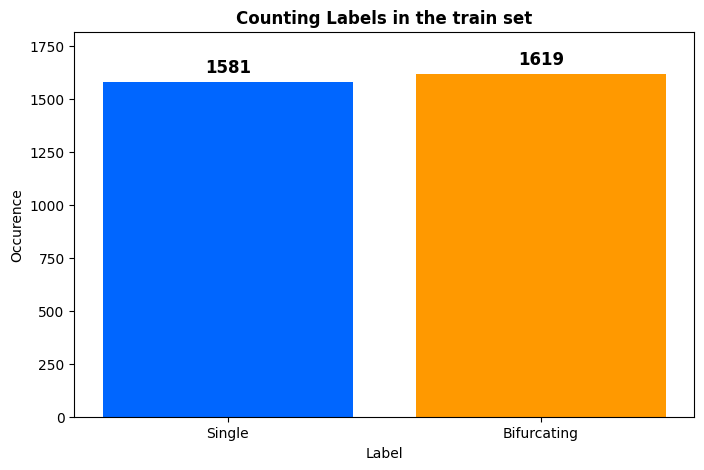

In [32]:
check_label_balance(global_var['train_path'])

## Scatter plot

In [33]:
def get_scatter_data(file_path):
    single_pressures = []
    single_wss = []
    bifurcating_pressures = []
    bifurcating_wss = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc="Getting scatter data"):
            # Shift to mPa (millPascal)
            pressure = file[sample]['pressure'][()]
            mean_pressure = np.array(pressure).mean() * 1e-3
            mean_wss = np.array(file[sample]['wss'][()]).mean()

            if file[sample]['label'][0] == 0:
                single_pressures.append(mean_pressure)
                single_wss.append(mean_wss)
            else:
                bifurcating_pressures.append(mean_pressure)
                bifurcating_wss.append(mean_wss)

    pressures = [single_pressures,bifurcating_pressures]
    wss = [single_wss,bifurcating_wss]

    return pressures,wss

In [34]:
def scatter_plot(file_path):
    pressures,wss = get_scatter_data(file_path)

    fig, ax = plt.subplots(figsize = (10,7))

    ax.scatter(
        pressures[0],
        wss[0],
        label = 'Single',
        alpha = 0.3
     )
    ax.scatter(
        pressures[1],
        wss[1],
        label = 'Bifurcating',
        alpha = 0.3
     )

    ax.set_xlabel('Mean Pressure')
    ax.set_ylabel('Mean WSS (Wall Shear Stress)')
    ax.set_title('Scatterplot between mean WSS e Pressure', weight = 'bold')

    ax.legend()
    plt.show()

Getting scatter data:   0%|          | 0/3200 [00:00<?, ?it/s]

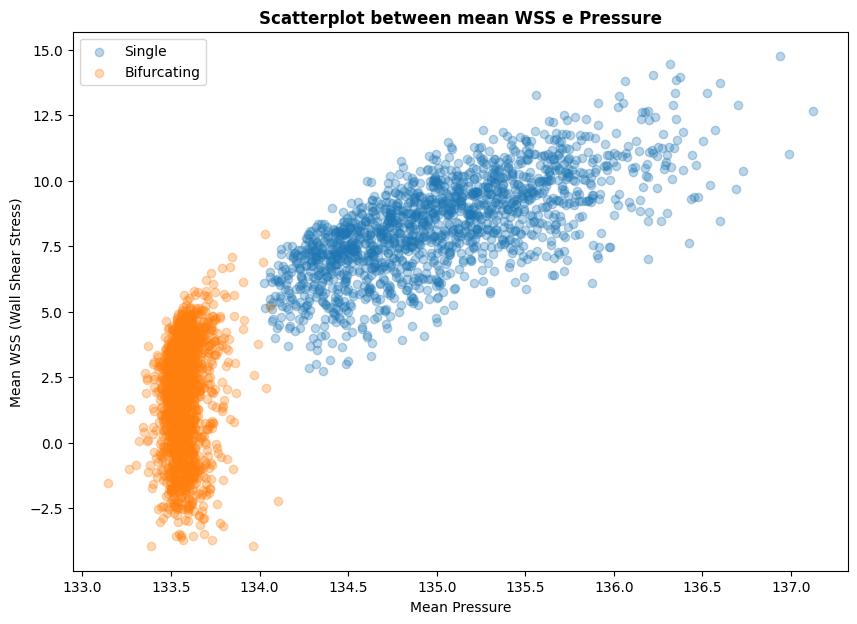

In [35]:
scatter_plot(global_var['train_path'])

# Baseline

# GATr primitives

## Equilinear layer

In [36]:
def get_pin_coeffs(device=torch.device("cpu"), dtype=torch.float32, normalize=True):
    basis_elements = [
        [0],
        [1, 2, 3, 4],
        [5, 6, 7, 8, 9, 10],
        [11, 12, 13, 14],
        [15],
        [(1, 0)],
        [(5, 2), (6, 3), (7, 4)],
        [(11, 8), (12, 9), (13, 10)],
        [(15, 14)],
    ]

    basis = []

    for elements in basis_elements:
        w = torch.zeros((16, 16))
        for element in elements:
            try:
                i, j = element
                w[i, j] = 1.0
            except TypeError:
                w[element, element] = 1.0

        if normalize:
            w /= torch.linalg.norm(w)

        w = w.unsqueeze(0)
        basis.append(w)

    catted_basis = torch.cat(basis, dim=0)

    return catted_basis.to(device=device, dtype=dtype)

In [37]:
class EquiLinearLayer(nn.Module):
    def __init__(self,input_mv_dim,output_mv_dim,pin_base,pin_coeffs):
        super(EquiLinearLayer,self).__init__()
        self.pin_base = pin_base
        self.weights = nn.Parameter(torch.rand(input_mv_dim,output_mv_dim,pin_coeffs))
        # self.weights = nn.Parameter(torch.empty(input_mv_dim,output_mv_dim,pin_coeffs))

    def forward(self,x):
        equivariant = self.pin_base @ self.weights.T
        output_mv = x @ equivariant
        return output_mv

In [38]:
pin_base = get_pin_coeffs()

equi_linear = EquiLinearLayer(
    input_mv_dim = global_var['ga_dimension'],
    output_mv_dim = global_var['ga_dimension'],
    pin_base = pin_base,
    pin_coeffs = len(pin_base)
)
data_module.setup()
equi_linear_data = data_module.train_dataloader()

In [39]:
equi_linear_input = next(iter(equi_linear_data))[0]
equi_linear_input_shape = equi_linear_input.shape
print(f"Input of equilinear layer: {equi_linear_input_shape}")

equi_linear_output = equi_linear(equi_linear_input)
equi_linear_output_shape = equi_linear_output.shape
print(f"Output of equilinear layer: {equi_linear_output_shape}")

Input of equilinear layer: torch.Size([2095421, 16])


<ipython-input-37-ddb5da4778f3>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  equivariant = self.pin_base @ self.weights.T


Output of equilinear layer: torch.Size([9, 2095421, 16])


In [40]:
print(np.isnan(equi_linear_input.detach().numpy()).any())
print(np.isinf(equi_linear_input.detach().numpy()).any())

False
False


In [41]:
print(np.isnan(equi_linear_output.detach().numpy()).any())
print(np.isinf(equi_linear_output.detach().numpy()).any())

False
False


## Equilinear norm

In [42]:
class EquilinearNormLayer(nn.Module):
    def __init__(self, input_mv_dim):
        super(EquilinearNormLayer,self).__init__()
        self.input_mv_dim = input_mv_dim


    def forward(self, x):
        inner_product = (x*x + x*x)/2
        squared_norms = torch.mean(inner_product, dim=self.input_mv_dim, keepdim=True)
        output = x/torch.sqrt(squared_norms)

        return output

In [43]:
equi_norm = EquilinearNormLayer(
    input_mv_dim = global_var['ga_dimension']
)

In [44]:
equi_norm_input = equi_linear_output
equi_norm_input_shape = equi_norm_input.shape
print(f"Input of equilinear norm layer: {equi_norm_input_shape}")

equi_norm_output = equi_linear(equi_norm_input)
equi_norm_output_shape = equi_norm_output.shape
print(f"Output of equilinear layer: {equi_norm_output_shape}")

Input of equilinear norm layer: torch.Size([9, 2095421, 16])
Output of equilinear layer: torch.Size([9, 2095421, 16])


In [45]:
print(np.isnan(equi_norm_output.detach().numpy()).any())
print(np.isinf(equi_norm_output.detach().numpy()).any())

False
False


## Geometric attention layer

## Geometric bilinear layer

## Gated GELU

In [46]:
class GatedGELU(nn.Module):
    def __init__(self):
        super(GatedGELU,self).__init__()
        self.gelu = nn.GELU()

    def gated_gelu(self,x):
        gates = x[...,[0]]
        weights = self.gelu(gates=gates)
        outputs = weights * x
        return outputs

In [47]:
gated_gelu = GatedGELU()

In [48]:
gated_gelu_input = equi_norm_output
gated_gelu_input_shape = gated_gelu_input.shape
print(f"Input of equilinear norm layer: {gated_gelu_input_shape}")

gated_gelu_output = equi_linear(gated_gelu_input)
gated_gelu_output_shape = gated_gelu_output.shape
print(f"Output of equilinear layer: {gated_gelu_output_shape}")

Input of equilinear norm layer: torch.Size([9, 2095421, 16])
Output of equilinear layer: torch.Size([9, 2095421, 16])


In [49]:
print(np.isnan(gated_gelu_output.detach().numpy()).any())
print(np.isinf(gated_gelu_output.detach().numpy()).any())

False
False


# GATr architecture

# Transformer

##Attention layer

In [ ]:
class AttentionLayer(pl.LightningModule):
    def __init__(self, dim_input, dim_output, bias=True):
        super(AttentionLayer,self).__init__()

        self.softm = nn.Softmax(dim=-1)

        self.n_input = dim_input
        self.n_output = dim_output

        self.query_transformation = nn.Linear(in_features=self.n_input, out_features=self.n_output, bias=bias)
        self.key_transformation   = nn.Linear(in_features=self.n_input, out_features=self.n_output, bias=bias)
        self.value_transformation = nn.Linear(in_features=self.n_input, out_features=self.n_output, bias=bias)

    def forward(self, mv):

        queries = self.query_transformation(mv)
        keys    = self.query_transformation(mv)
        values  = self.query_transformation(mv)

        num = torch.dot(queries, keys)
        den = torch.sqrt(self.n_output)
        attention_value = self.softm( num/den )*values

        return attention_value

##Normalizer layer

In [ ]:
class NormalizerLayer(pl.LightningModule):
    def __init__(self):
        super(AttentionLayer,self).__init__()

    def forward(self, mv):
        mean = torch.mean(mv, dim=1 keepdim=True)
        deviation = torch.std(mv, dim=1, keepdim=True)

        normalized_data = (mv-mean)/deviation

        return normalized_data

## Encoder

In [ ]:
def get_positional_encoding(mvs, model_dimension):

    return

In [ ]:
class Encoder(pl.LightningModule):
    def __init__(self, dim_input, dim_output, bias=True):
        super(Encoder,self).__init__()

        self.n_input = dim_input
        self.n_output = dim_output

        self.attention_layer  = AttentionLayer(dim_input=self.n_input, dim_output=self.n_output, bias=bias)
        self.normalizer_layer = NormalizerLayer()
        self.feed_forward     = nn.Linear(in_features=self.n_input, out_features=self.n_output, bias=bias)

    def forward(self, mvs):

        # implement positional encoding
        positional_mvs   = mvs + get_positional_encoding(mvs, self.n_output)
        output_attention     = self.attention_layer( positional_mvs )
        normalized_attention = self.normalizer_layer( positional_mvs + output_attention )

        output_feedforward     = self.feed_forward( normalized_attention )
        normalized_feedforward = self.normalizer_layer( normalized_attention + output_feedforward )

        return normalized_feedforward

## Decoder

In [ ]:
class Decoder(pl.LightningModule):
    def __init__(self):
        super(Decoder,self).__init__()

    def forward(self, multivector):
        return

## Transformer architecture

In [ ]:
class Transformer(pl.LightningModule):
    def __init__(self):
        super(Transformer,self).__init__()

    def forward(self, multivector):
        return

    def training_step(self, batch):
        x, y = batch

        # check if the used loss is correct according to the paper, find it on the github
        loss = F.binary_cross_entropy(x, y) # In case we need to adjust dimension
        #loss = F.binary_cross_entropy(self(x).view(-1), y.float())

        #predictions = self.forward(x).long().squeeze()
        #y = torch.tensor(y, dtype=torch.long)

        #accuracy  = accuracy(predictions, y)
        #precision = self.precision_metric(predictions, y)
        #recall    = self.recall_metric(predictions, y)
        #f1_score  = self.f1_metric(predictions, y)

        #wandb.log({"acc": accuracy,"loss": loss,"precision": precision, "recall": recall, "f1-score:":f1_score })

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

# Train

# Evaluation